In [ ]:
!pip install mne scipy
!pip install pyqt5
!pip install keras-tuner

import scipy.io
import numpy as np
import matplotlib
import mne
import os
import pathlib
import pandas as pd
import shutil
from pathlib import Path
import keras_tuner as kt

matplotlib.use('Agg')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import mne
import tensorflow as tf
import keras_tuner
import os
import subprocess

# Get the MNE version
print("MNE version:", mne.__version__)

# Get the TensorFlow and Keras version
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)  # Keras is part of TensorFlow in recent versions

# Get the Keras Tuner version
print("Keras Tuner version:", keras_tuner.__version__)

# Check if running on Google Colab and get the version
if 'COLAB_GPU' in os.environ:
    colab_version = subprocess.run(['pip', 'show', 'google-colab'], capture_output=True, text=True)
    version_line = next((line for line in colab_version.stdout.split('\n') if "Version" in line), None)
    print("Google Colab version:", version_line)
else:
    print("Not running on Google Colab")


MNE version: 1.8.0
TensorFlow version: 2.17.0
Keras version: 3.4.1
Keras Tuner version: 1.4.7
Google Colab version: Version: 1.0.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

eeg_data = np.load('/content/drive/My Drive/mindlock-eeg-files/session-1/data-labels/for-train-data.npy')
eeg_labels = np.load('/content/drive/My Drive/mindlock-eeg-files/session-1/data-labels/for-train-labels.npy')

from sklearn.utils import shuffle
eeg_data, eeg_labels = shuffle(eeg_data, eeg_labels, random_state=42)

import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(eeg_data, eeg_labels, test_size=0.2, random_state=42)

Mounted at /content/drive


In [ ]:
eeg_data.shape

(12180, 64, 251, 1)

In [ ]:
testing_data = np.load('/content/drive/My Drive/mindlock-eeg-files/session-1/for-testing/model-testing-data.npy')

testing_data.shape

(2295, 64, 251, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#determine mne version, cnn, hyperband, python na ginamit

def build_model(hp):
    cnn_model = Sequential()

    cnn_model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=8, max_value=64, step=8),
        kernel_size=(3, 3),
        input_shape=(X_train.shape[1], X_train.shape[2], 1),
        padding='same',
        kernel_regularizer=l2(hp.Float('l2_1', min_value=0.001, max_value=0.2, step=0.01))
    ))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


    cnn_model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=8, max_value=64, step=8),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


    cnn_model.add(Conv2D(
        filters=hp.Int('filters_3', min_value=8, max_value=64, step=8),
        kernel_size=(3, 3),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_2', min_value=0.01, max_value=0.2, step=0.01)),
        padding='same'
    ))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


  #  cnn_model.add(Conv2D(
   #     filters=hp.Int('filters_2', min_value=8, max_value=64, step=8),
    #    kernel_size=(3, 3),
     #   activation='relu',
      #  padding='same'
   # ))
   # cnn_model.add(BatchNormalization())
    # cnn_model.add(MaxPooling2D(pool_size=(2, 2)))


    cnn_model.add(Flatten())

    cnn_model.add(Dense(
        units=hp.Int('dense_units', min_value=8, max_value=128, step=32),
        activation='relu'
    ))

    if hp.Boolean('dropout'):
        cnn_model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.01)))

    cnn_model.add(Dense(85, activation='softmax'))

    optm = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    cnn_model.compile(optimizer=optm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return cnn_model


In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='for-train-model-2'
)

stop_early = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# tuner search
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[stop_early])

# best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best hyperparameters:
- filters_1: {best_hps.get('filters_1')}
- filters_2: {best_hps.get('filters_2')}
- filters_3: {best_hps.get('filters_3')}
- dense_units: {best_hps.get('dense_units')}
- dropout: {best_hps.get('dropout')}
- dropout_rate: {best_hps.get('dropout_rate')}
- l2_1: {best_hps.get('l2_1')}
- l2_2: {best_hps.get('l2_2')}
- learning_rate: {best_hps.get('learning_rate')}
""")

Trial 30 Complete [00h 01m 57s]
val_accuracy: 0.1410979926586151

Best val_accuracy So Far: 0.9579271674156189
Total elapsed time: 00h 26m 43s

The best hyperparameters:
- filters_1: 56
- filters_2: 56
- filters_3: 16
- dense_units: 72
- dropout: True
- dropout_rate: 0.43000000000000005
- l2_1: 0.07100000000000001
- l2_2: 0.09999999999999999
- learning_rate: 0.00033904359243909244



In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

best_model = tuner.hypermodel.build(best_hps)

stop_early = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = best_model.fit(X_train, y_train,
                         validation_split=0.2,
                         epochs=30,
                         batch_size=32,
                         callbacks=[stop_early, reduce_lr],
                         verbose=1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

def get_learning_rates(history):
    lr = []
    for i in range(len(history.epoch)):
        lr.append(history.model.optimizer.learning_rate.numpy())
    return lr

Epoch 1/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.0291 - loss: 6.6810 - val_accuracy: 0.0677 - val_loss: 5.1858 - learning_rate: 3.3904e-04
Epoch 2/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0852 - loss: 4.8537 - val_accuracy: 0.1098 - val_loss: 4.5454 - learning_rate: 3.3904e-04
Epoch 3/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.1848 - loss: 3.9141 - val_accuracy: 0.2606 - val_loss: 3.4415 - learning_rate: 3.3904e-04
Epoch 4/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.2951 - loss: 3.1481 - val_accuracy: 0.4659 - val_loss: 2.4822 - learning_rate: 3.3904e-04
Epoch 5/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.4331 - loss: 2.4104 - val_accuracy: 0.6947 - val_loss: 1.5192 - learning_rate: 3.3904e-04
Epoch 6/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5591 - loss: 1.8012 - val_accuracy: 0.7712 - val_loss: 1.1266 - learning_rate: 3.3904e-04
Epoch 7/30
244/244 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/ste

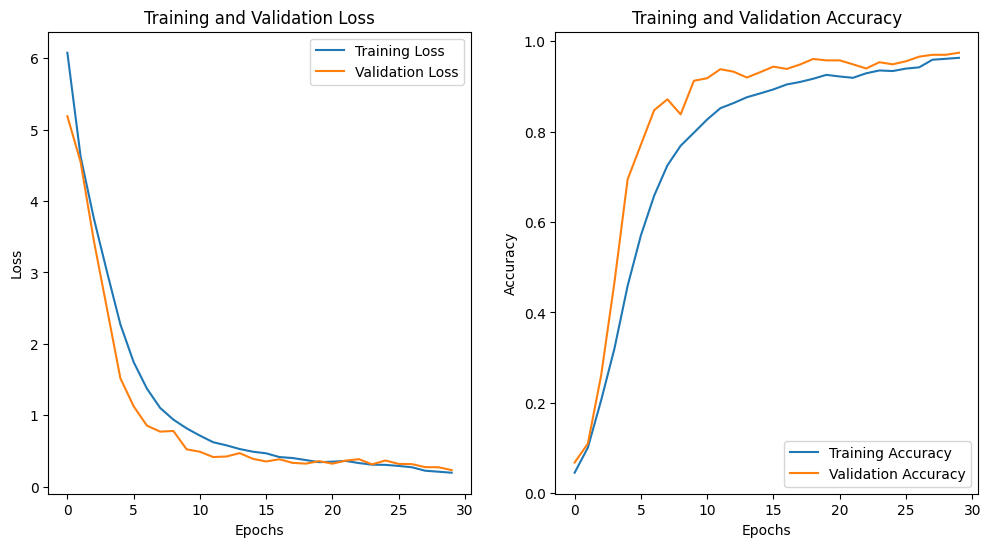

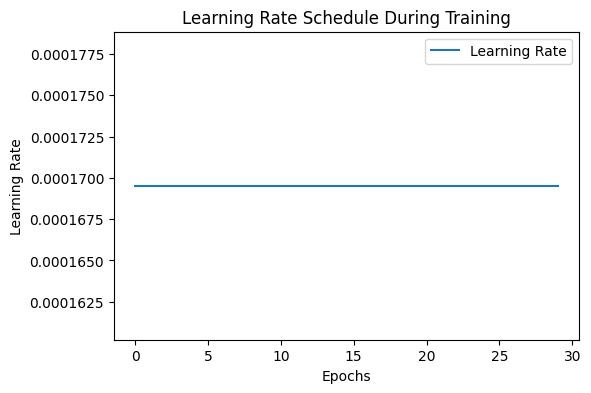

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

learning_rates = get_learning_rates(history)
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot learning rate changes
plt.figure(figsize=(6, 4))
plt.plot(learning_rates, label='Learning Rate')
plt.title('Learning Rate Schedule During Training')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model_save_path = '/content/drive/MyDrive/mindlock-eeg-files/model/for-train-model-1.keras'
best_model = load_model(model_save_path)

In [ ]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 64, 251, 56)         │             560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 251, 56)         │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 125, 56)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 125, 56)         │          28,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 125, 56)         │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 62, 56)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 62, 16)          │           8,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 31, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 72)                  │         285,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 72)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 85)                  │           6,205 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 987,705 (3.77 MB)

 Trainable params: 329,149 (1.26 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 658,300 (2.51 MB)

In [ ]:
import pickle
from joblib import load

svm_model_path = '/content/drive/MyDrive/mindlock-eeg-files/model/for-train-svm_model.pkl'
svm_model = load(svm_model_path)

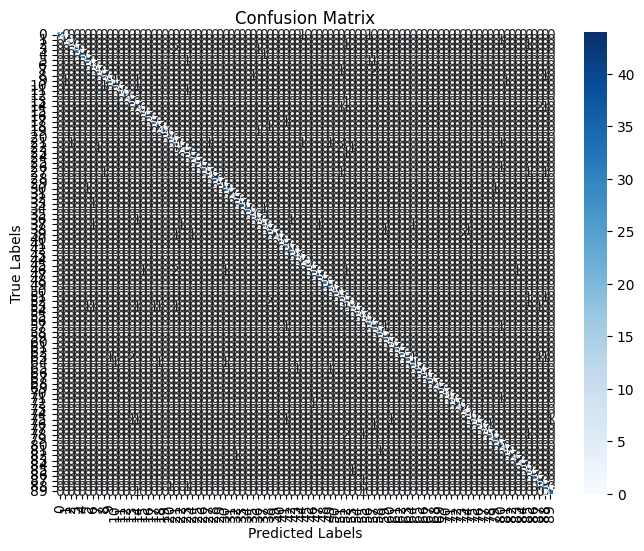

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           1       0.98      0.98      0.98        41
           2       0.98      0.96      0.97        46
           3       1.00      0.91      0.95        32
           4       1.00      0.96      0.98        28
           5       0.94      0.91      0.93        35
           6       0.92      1.00      0.96        36
           7       0.97      0.91      0.94        33
           8       0.94      0.94      0.94        34
           9       0.97      0.88      0.92        33
          10       0.94      0.94      0.94        34
          11       1.00      0.97      0.99        39
          12       1.00      1.00      1.00        34
          13       0.93      0.98      0.95        42
          14       0.85      0.87      0.86        38
          15       0.98      1.00      0.99        44
          16       1.00      1.00      1.00        32
    

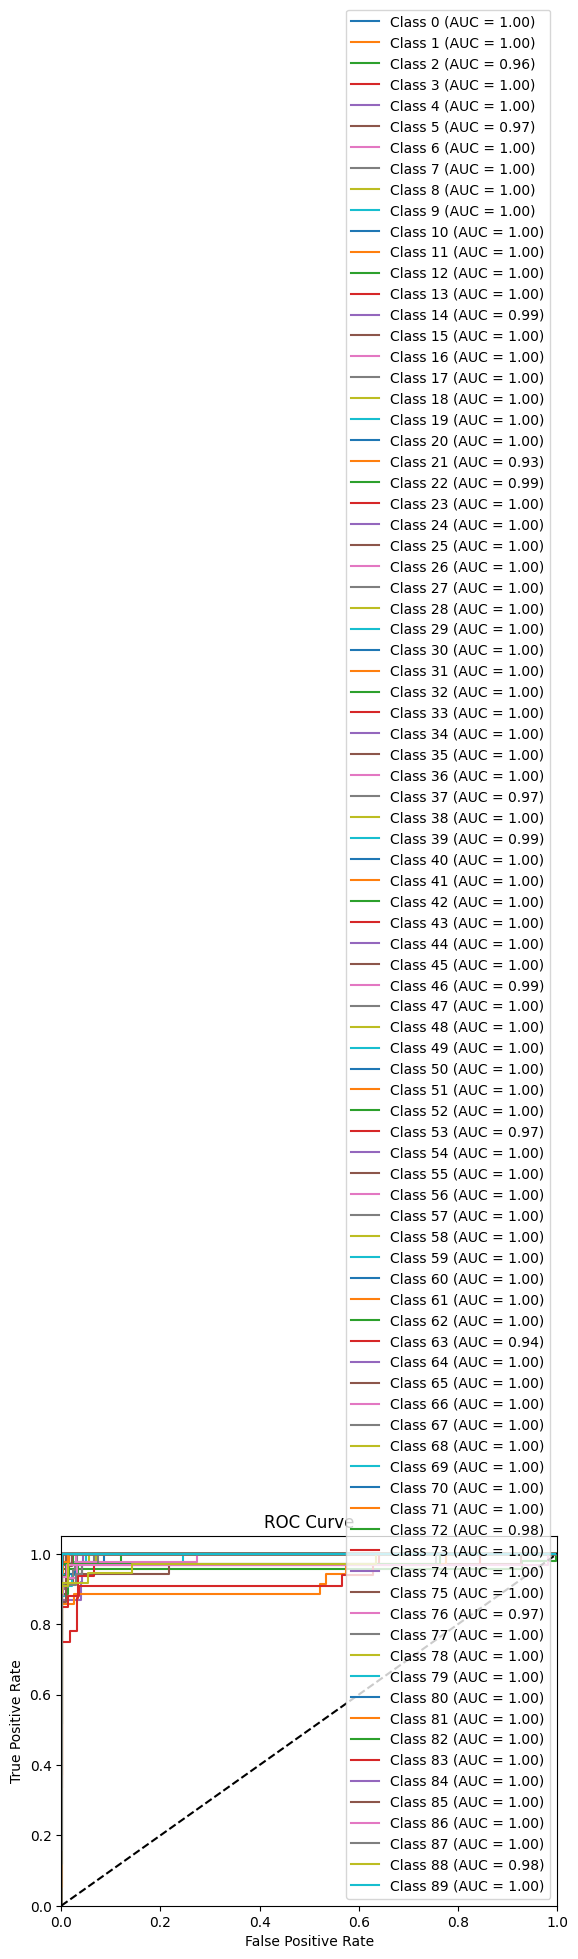

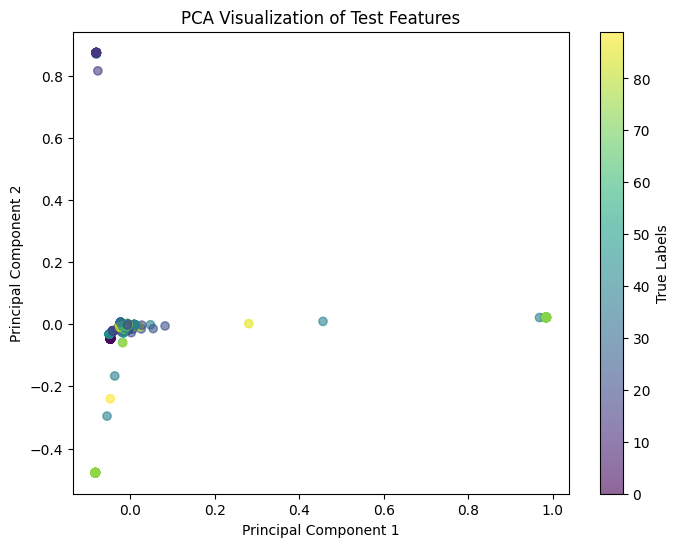

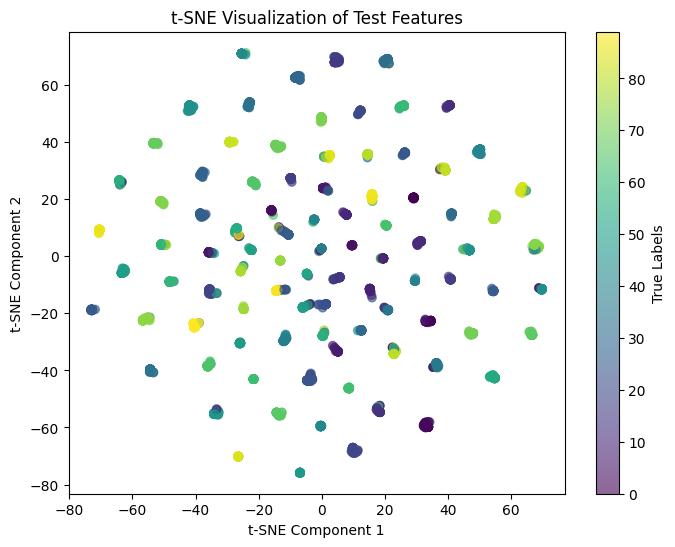

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import numpy as np

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 2. Precision, Recall, F1-Score Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 3. ROC Curve & AUC

lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

# Compute ROC curve and AUC for each class
for i in range(len(lb.classes_)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], svm_model.decision_function(X_test_features)[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_test_pca = PCA(n_components=2).fit_transform(X_test_features)

plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', alpha=0.6)
plt.title('PCA Visualization of Test Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='True Labels')
plt.show()

X_test_tsne = TSNE(n_components=2).fit_transform(X_test_features)

plt.figure(figsize=(8, 6))
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.6)
plt.title('t-SNE Visualization of Test Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='True Labels')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

X_train_features = best_model.predict(X_train)
X_test_features = best_model.predict(X_test)

X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

from sklearn.svm import SVC
svm_model = SVC(kernel='rbf') #linear 1 rbf 2
svm_model.fit(X_train_features, y_train)

y_pred = svm_model.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')


print(f'Accuracy on labeled test set: {accuracy * 100:.2f}%')
print(f'Precision on labeled test set: {precision * 100:.2f}%')
print(f'Recall on labeled test set: {recall * 100:.2f}%')

305/305 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Accuracy on labeled test set: 97.33%
Precision on labeled test set: 97.43%
Recall on labeled test set: 97.29%


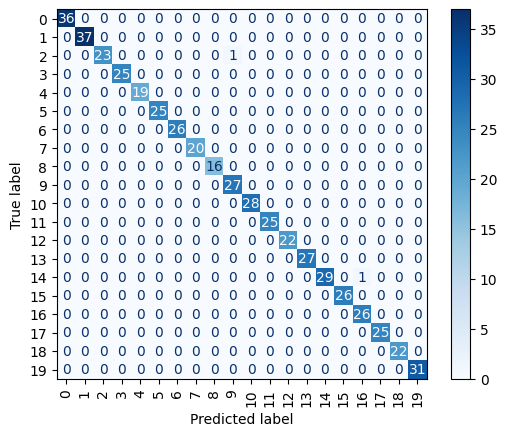

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Confusion Matrix
num_classes_to_display = 20

filtered_y_test = np.array([y for y in y_test if y < num_classes_to_display])
filtered_y_pred = np.array([y_pred[i] for i in range(len(y_pred)) if y_test[i] < num_classes_to_display])

cm_filtered = confusion_matrix(filtered_y_test, filtered_y_pred, labels=range(num_classes_to_display))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_filtered, display_labels=range(num_classes_to_display))
disp.plot(cmap='Blues')

plt.title('')
plt.xticks(rotation=90)
plt.show()

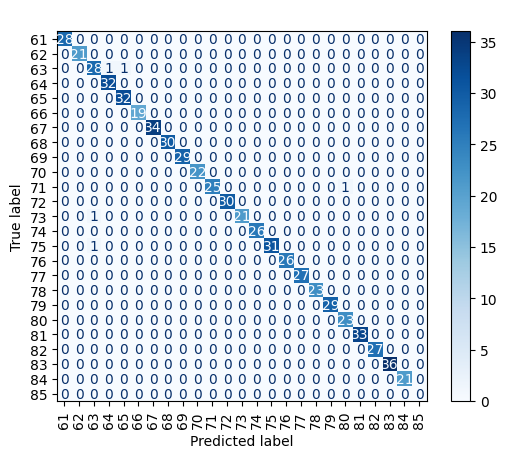

In [ ]:
# Display Confusion Matrix for classes 21 to 40
num_classes_to_display = 25
class_offset = 60  # This will shift the class range to 21-40

# Filter predictions and true labels for classes 21 to 40
filtered_y_test = np.array([y for y in y_test if 60 < y <= 85])
filtered_y_pred = np.array([y_pred[i] for i in range(len(y_pred)) if 60 < y_test[i] <= 85])

# Update class labels to 21-40
cm_filtered = confusion_matrix(filtered_y_test, filtered_y_pred, labels=range(61, 86))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_filtered, display_labels=range(61, 86))

# Plot confusion matrix
disp.plot(cmap='Blues')
plt.title(' ')
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
csv_path = '/content/drive/MyDrive/mindlock-eeg-files/session-1/classification-report.csv'

report_df.to_csv(csv_path, index=True)

Classification report saved to /content/drive/MyDrive/mindlock-eeg-files/session-1/classification-report.csv


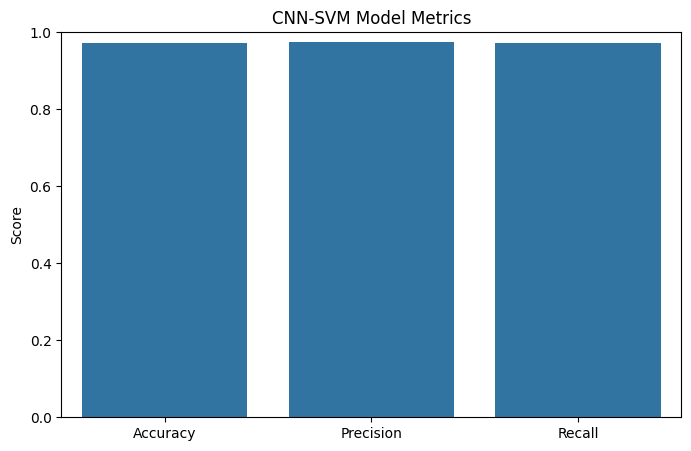

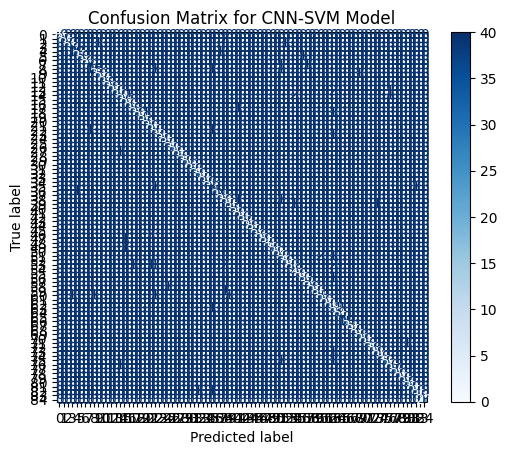

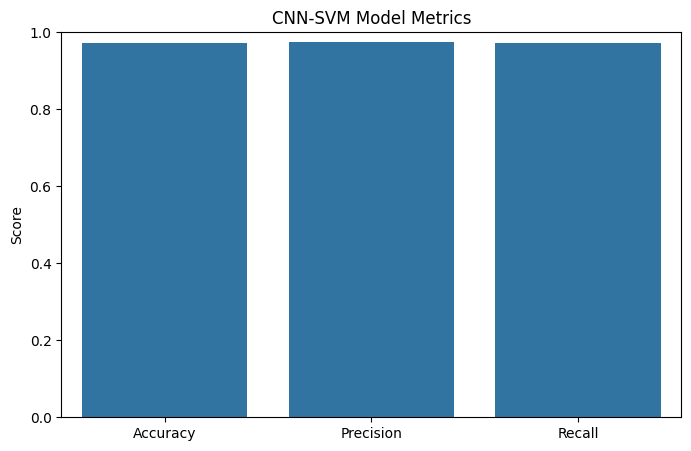

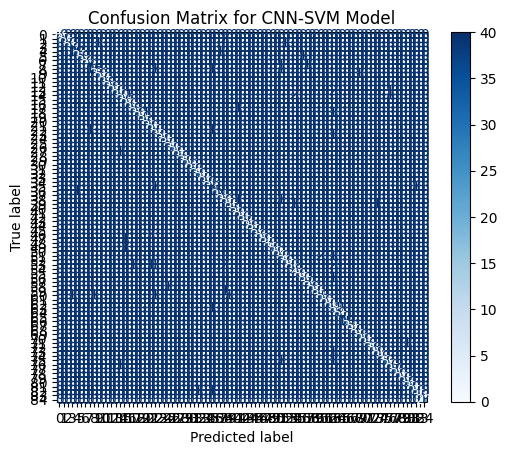

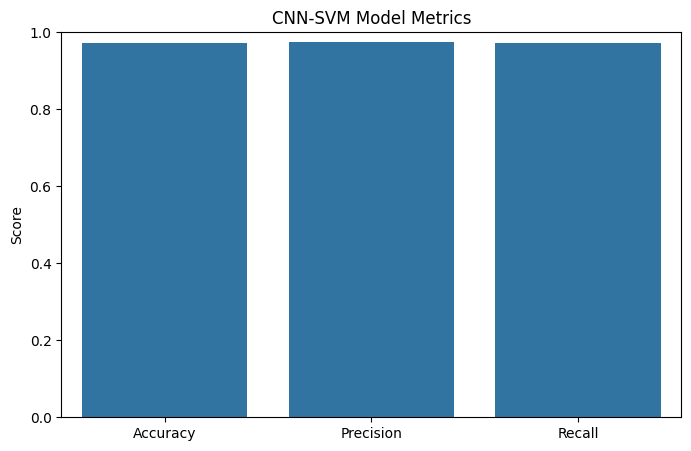

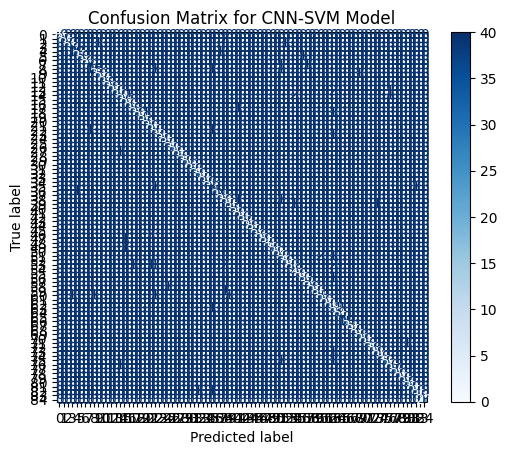

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 5))
metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]
sns.barplot(x=metrics, y=values)
plt.title('CNN-SVM Model Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for CNN-SVM Model')
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib

X_train_features = best_model.predict(X_train)
X_test_features = best_model.predict(X_test)

X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear']
}

svm_model = SVC()

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_features, y_train)


best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

best_svm_model = SVC(**best_params)
best_svm_model.fit(X_train_features, y_train)

y_pred = best_svm_model.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on labeled test set: {accuracy * 100:.2f}%')




305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best parameters found: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Accuracy on labeled test set: 97.21%


In [ ]:
model_save_path = '/content/drive/My Drive/mindlock-eeg-files/session-1/best_svm_model.joblib'
joblib.dump(best_svm_model, model_save_path)

print(f"Model saved to {model_save_path}")


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 98.21%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      0.90      0.91        40
           2       1.00      0.92      0.96        37
           3       1.00      1.00      1.00        45
           4       0.97      1.00      0.98        29
           5       0.97      1.00      0.98        32
           6       1.00      1.00      1.00        34
           7       1.00      0.95      0.97        41
           8       1.00      1.00      1.00        30
           9       0.97      0.93      0.95        42
          10       1.00      0.98      0.99        44
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        31
          13       0.84      1.00      0.92        27
          14       0.98      0.98      0.98        43
          15       1.00      1.00      1.00        35
          16       1.00      1.00      1

In [ ]:
X_train_features = best_model.predict(X_train)
X_test_features = best_model.predict(X_test)

426/426 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_features, y_train)

y_pred = svm_model.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

first_10_classes = np.unique(y_test)[:10]

cm_first_5 = cm[:10, :10]

Accuracy: 97.53%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.98      1.00      0.99        40
           2       0.89      0.92      0.91        37
           3       0.98      0.98      0.98        45
           4       1.00      1.00      1.00        29
           5       0.97      0.91      0.94        32
           6       0.97      1.00      0.99        34
           7       1.00      1.00      1.00        41
           8       1.00      0.93      0.97        30
           9       0.95      0.98      0.96        42
          10       0.98      0.98      0.98        44
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        31
          13       0.90      1.00      0.95        27
          14       0.83      0.88      0.85        43
          15       1.00      1.00      1.00        35
          16       1.00      1.00      1

In [ ]:
from sklearn.utils import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

# Shuffle data
eeg_data, eeg_labels = shuffle(eeg_data, eeg_labels, random_state=42)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(eeg_data, eeg_labels, test_size=0.2, random_state=42)

# Load fine-tuned model
model_save_path = '/content/drive/MyDrive/mindlock-eeg-files/model/fine-tune-sub086.keras'
best_model_fine_tuned = load_model(model_save_path)

# Predict class probabilities or logits for the test set
X_test_predictions = best_model_fine_tuned.predict(X_test)

# If model outputs probabilities, convert to class labels by choosing the class with the highest probability
y_test_pred = np.argmax(X_test_predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy of fine-tuned model on test set: {accuracy * 100:.2f}%')


77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step
Accuracy of fine-tuned model on test set: 0.57%
